 <h1>Описание проекта</h1>


Я — аналитик крупного интернет-магазина. Есть список гипотез для увеличения выручки.
Нужно приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

<h1>Цель исследования</h1>

 - приоритизировать гипотезы в 1 части проекта
 - провести A/B тест по сырым данным
 - обработать данные от аномальных значений и провести тест по фильтрованным данным
 - сравнить результаты тестов
 - сделать ыводы и принять решение

<h1>Ход исследования </h1>

Данные я получу из файлов /datasets/hypothesis.csv, /datasets/orders.csv и /datasets/visitors.csv. Далее я проведу обзор данных и их предобработку.

этапы исследования:
 - обзор данных
 - предобработка данных
 - приоритизация гипотез методами ICE и RICE
 - анализ различий при применении RICE вместо ICE 
 - построить графики кумулятивных значений, сделать выводы
 - Провести A/B тест по сырым данным
 - Провести A/B тест по очищенным данным
 - принять решение на основе теста


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
from scipy import stats as st
import datetime as dt


In [4]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv', sep=',')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', sep=',')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', sep=',')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
visitors.head() 

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
#приведём столбцы к привычному стилю
hypothesis.columns = hypothesis.columns.str.lower()   
orders.columns = orders.columns.str.lower() 
visitors.columns = visitors.columns.str.lower()   
   

In [8]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Видим, что у дат тип данных object - заменим тип данных
также заменим тип данных у столбца hypothesis 

In [11]:
hypothesis['hypothesis'] = hypothesis['hypothesis'].astype(str)

In [12]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
# преобразование данных о времени
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)  

In [13]:
visitors.duplicated().sum()

0

In [14]:
orders.duplicated().sum()

0

In [15]:
hypothesis.duplicated().sum()

0

In [16]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [17]:
orders.isna().sum()

transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64

In [18]:
hypothesis.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

дубликатов и пропусков нет

В ходе предобработки заменили тип данных у столбцов date в датафреймах orders и visitors и у столбца hypothesis в датафрейме hypothesis. Привели столбцы к привычному стилю.
Выяснили, что дубликатов и пропусков нет 

In [19]:
#Применение фреймворка ICE
#ICE score = (Impact x Confidence) / Efforts
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False))


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


In [20]:
pd.set_option('display.max_colwidth', 0)

Наиболее перспективные гипотезы по ICE: 8,0,7

In [21]:
hypothesis['RICE'] = (hypothesis['reach'] *  hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE: 7,2,0,6. Причём у гипотез 0 и 6 показатель RICE одинаковый
Теперь приоритетность гипотез полностью изменилась. Приоритетной и в первом, и во втором методе осталась только гипотеза 0

In [22]:
#объяснение
hypothesis.sort_values(by=['ICE','RICE'],ascending=True)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


Видим, что у гипотезы 7 reach выше, чем у остальных. У гипотезы 8 самый низкий параметр reach, поэтому при расчёте методом RICE она оказалась в конце и не попала в список приоритетных. Также высокий параметр reach имеет гипотеза 2.
Таким образом, параметр reach повлиял на изменение приоритетности гипотез


<b>Анализ A/B-теста</b>

In [23]:
#проверим, есть ли в данных пользователи, принадлежащие к обеим группам
duplicates_users = orders.groupby('visitorid').agg({'group':'nunique'}).query('group > 1').reset_index()
duplicates_users


,visitorid,group
0,8300375,2
1,199603092,2
2,232979603,2
3,237748145,2
4,276558944,2
5,351125977,2
6,393266494,2
7,457167155,2
8,471551937,2
9,477780734,2


In [24]:
len(duplicates_users)

58

Такие пользователи есть, их 58. Удалим их

In [25]:
orders = orders[~orders['visitorid'].isin(duplicates_users['visitorid'])]

In [26]:
#Создадим массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

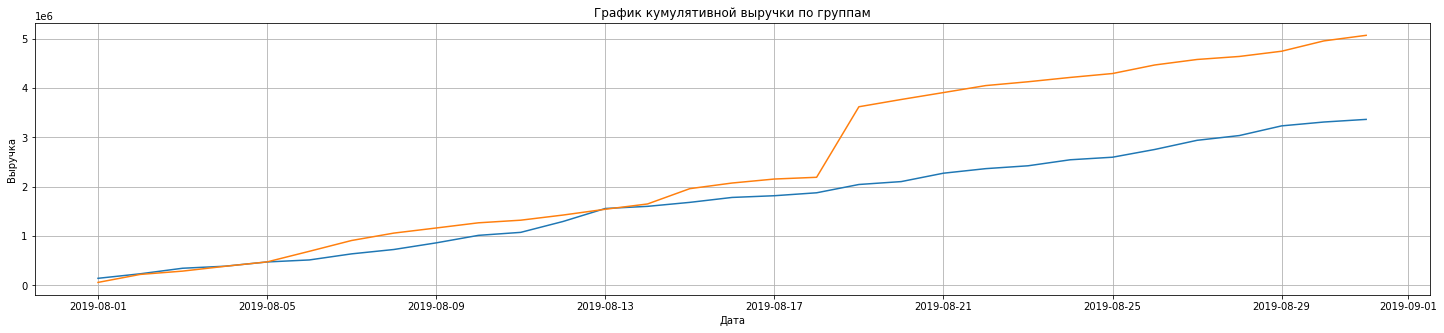

In [27]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(25,5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()


Выручка почти равномерно увеличивается в течение всего теста. С 18.08.2019 наблюдается резкий рост выручки у группы В. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке, либо о высоком среднем чеке

Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

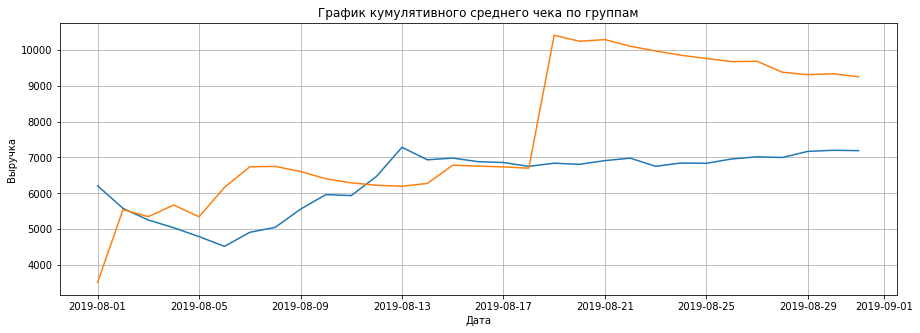

In [59]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()


Значение среднего чека нестабильно в первой половине теста. Средний чек становится равномерным начиная с середины теста для группы A и резко растёт для группы B, начиная с 18.08.2019. Возможно, в группу B во второй половине теста попали крупные заказы 

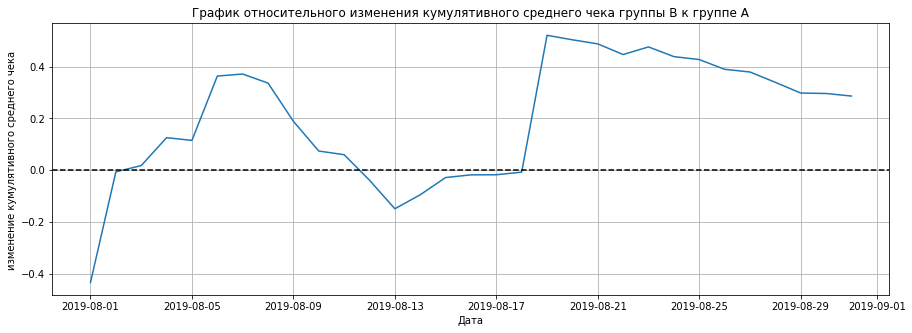

In [35]:
#Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('изменение кумулятивного среднего чека ')
plt.grid()


В определённые даты график различия между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы! Наверняка в эти даты были сделаны аномальные заказы

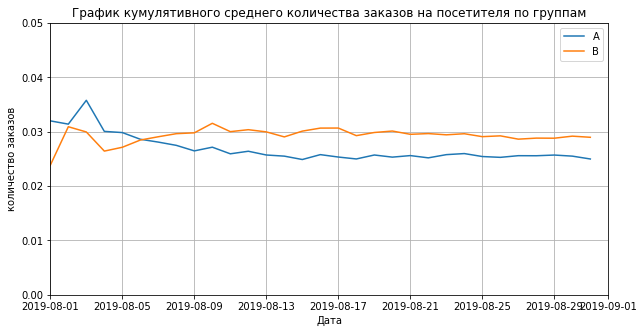

In [36]:
#Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(10,5))
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])

plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('количество заказов')
plt.grid()


Симметричный график получился! В начале среднее количество заказов группы A было выше, но затем количество заказов группы B вырвалось вперёд и зафиксировалось, а количество заказов группы А просело и также зафиксировалось.

Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

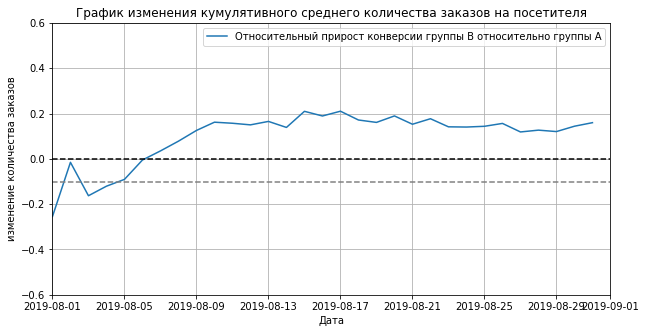

In [37]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.6, 0.6])
plt.title('График изменения кумулятивного среднего количества заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('изменение количества заказов')
plt.grid()



С 06.08.2019 среднее количество заказов группы B стабильно выше, чем у группы A, то есть почти с начала теста. Количество заказов группы В выше, чем у группы А в среднем на 15%-20%.

Text(0, 0.5, 'Кол-во заказов')

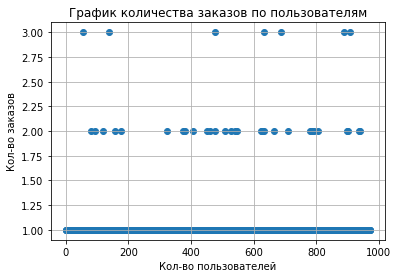

In [38]:
#Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
kol = orders.groupby('visitorid')['transactionid'].count()
x_values = pd.Series(range(0, len(kol)))
plt.scatter(x_values, kol) 
plt.grid()
plt.title('График количества заказов по пользователям')
plt.xlabel('Кол-во пользователей')
plt.ylabel('Кол-во заказов')

Есть пользователи, сделавшие более одного заказа, но их очень мало. Даже 3 заказа - редкое значение. Большинство пользователей делают 1 заказ. По графику можно выбрать границу количества аномальных заказов от 2 до 3. 

In [39]:
#Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. 
#Выберите границу для определения аномальных пользователей.
print(np.percentile(kol, [95, 99])) 


[1. 2.]


не более 5% пользователей совершают больше 1 заказа, не более 1% совершают более двух заказов. Всё, что больше 2 заказов будет аномальным

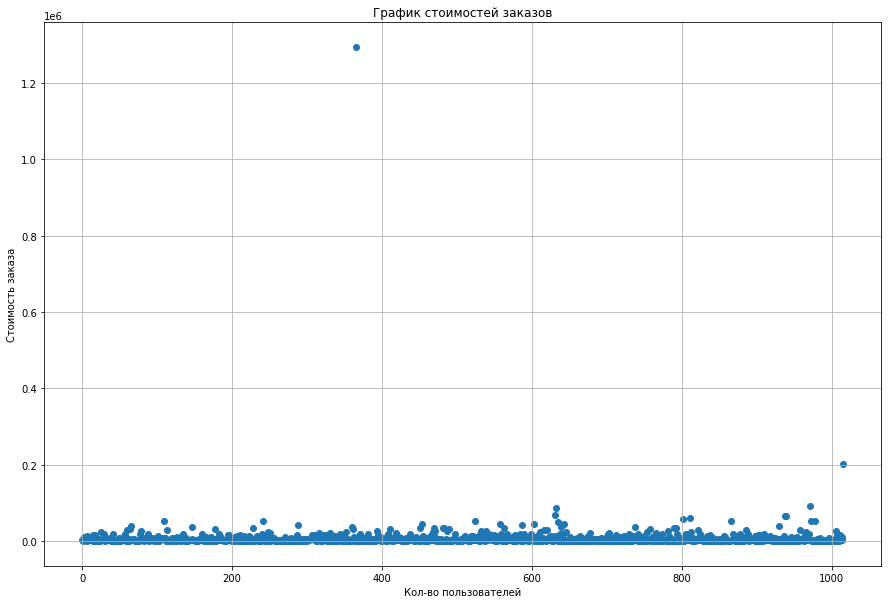

In [40]:
#Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,10))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('Кол-во пользователей')
plt.ylabel('Стоимость заказа')
plt.scatter(x_values, orders['revenue'])


По графику видно, что всё, что больше 0.2 - аномальные значения, удалим их 

In [41]:
orders['revenue'].sort_values(ascending=False)

425     1294500
1196    202740 
1136    92550  
744     86620  
743     67990  
        ...    
404     70     
933     60     
584     50     
756     50     
459     50     
Name: revenue, Length: 1016, dtype: int64

Аномальные заказы - 425 и 1196

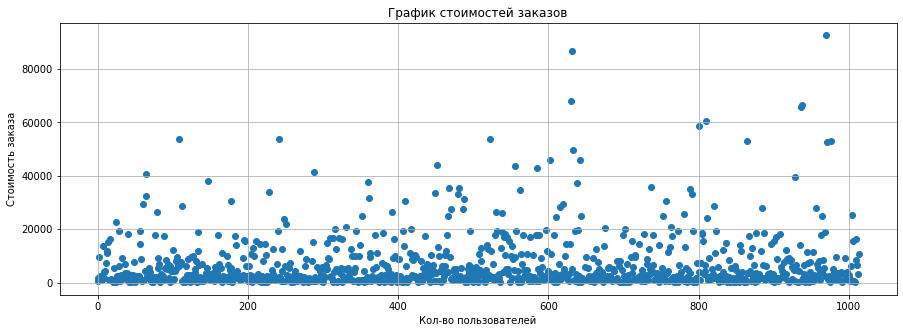

In [42]:
orders_2 = orders.query("revenue < 202740")
x2_values = pd.Series(range(0,len(orders_2)))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('Кол-во пользователей')
plt.ylabel('Стоимость заказа')
plt.scatter(x2_values, orders_2['revenue'])

Большинство заказов стоят меньше 20000

In [43]:
#Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
print(np.percentile(orders['revenue'], [95, 99])) 


[26785. 53904.]


Не более 5% заказов дороже 26785 рублей и не более 1% дороже 53904 рублей. Заказы стоимостью выше 53904 - аномальные

- гипотеза H0 - статистически значимых различий в среднем количестве заказов между группами нет
- гипотеза Н1 - статистически значимые различия есть

Уровень alpha возьмём равный 0.05. 
Воспользуемсся критерием Манна-Уитни

In [44]:
#Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 
#Сделайте выводы и предположения.
import scipy.stats as stats
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)



ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']


sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("относительный прирост среднего количества заказов = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))







p-value = 0.011
относительный прирост среднего количества заказов = 0.160


p-value меньше 0.05. Поэтому нулевую гипотезу отвергаем.
Это значит что в среднем количестве заказов между группами A и B есть статистически значимые различия. Относительный прирост среднего количества заказов группы В к А равен 16% 

Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
Сделайте выводы и предположения.
гипотеза H0 - статистически значимых различий по "сырым данным" в среднем чеке между группами нет.
гипотеза Н1 - статистически значимые различия есть.




In [45]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('прирост среднего чека {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.829
прирост среднего чека 0.287


p-value значительно больше 0.05. Значит, значимых различий в среднем чеке между группами нет. Средний чек группы B значительно выше чем средний чек группы А (на 29%)

Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
 - Очистим данные от аномальных значений по количеству заказов и их стоимости

In [46]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64
16


Всего 16 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [47]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                                       name='orders')],axis=0) 

гипотеза H0 - статистически значимых различий по отфильтрованным данным в среднем количестве заказов между группами нет. <br>
гипотеза Н1 - статистически значимые различия есть.

In [48]:
#Применим статистический критерий Манна-Уитни к полученным выборкам:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительный прирост среднего количества заказов = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 




p-value = 0.007
относительный прирост среднего количества заказов = 0.189


p-value меньше 0.05. Нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов между группами нет отвергаем. По «очищенным» данным тоже есть статистически значимые различия в среднем количестве заказов. Относительный прирост среднего количества заказов группы В к А равен 19%, что немного выше, чем с сырыми данными. 

Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
Нулевая гипотеза H0: статистически значимых различий в средних чеках между группами нет
гипотеза Н1 - статистически значимые различия есть



In [74]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "прирост среднего чека {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value = 0.788
прирост среднего чека -0.032


p-value значительно больше 0.05. Значит, значимых различий в среднем чеке между группами нет.Средний чек группы B немного (на 3%) ниже среднего чека группы A, но по сырым данным он наоборот был больше на 29%. Видимо, сильно повлияли аномальные дорогие заказы

<b>РЕШЕНИЕ</b>
- Какие выводы по тесту можем сделать?
 - Имеющиеся факты:
 - Среднее количество заказов группы В выше на 16%, чем у группы А по сырым данным и на 19% выше по данным после фильтрации аномалий;
 - Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
 - График различия среднего количества заказов между группами сообщает, что результаты группы А хуже группы B 
 - В группе В имеются аномально дорогие заказы
 
 
Исходя из обнаруженных фактов, тест следует остановить и признать победу группы B. Так как её среднее количество заказов больше по всем данным
